# SpaSEG

**SpaSEG**, an unsupervised convolutional neural network-based method towards multiple SRT analysis tasks by jointly learning transcriptional similarity between spots and their spatial dependence within tissue. **SpaSEG** adopts edge strength constraint to enable coherent spatial domains, and allows integrative SRT analysis by automatically aligning spatial domains across multiple adjacent sections. Moreover, **SpaSEG** can effectively detect spatial domain-specific gene expression patterns(SVG), and infer intercellular interactions and co-localizations[[Bai23]](https://www.biorxiv.org/content/10.1101/2022.11.16.516728v2.full).

This function can be run on GPU, if you want to use GPU, you need to create an environment according to the guide [Clustering_by_GPU](../Tutorials/Clustering_by_GPU.html).


<div class="alert alert-info">

**Note**

Before anlysing, you also need to install a necessary package: **torch**

        CPU: pip install torch==1.10.0

        GPU: pip install torch==1.10.0+cu113 --extra-index-url https://download.pytorch.org/whl/

</div>

In [1]:
import os
from natsort import natsorted
from glob import glob
import stereo as st
from stereo.core.ms_data import MSData
from stereo.core.ms_pipeline import slice_generator

## Reading Data

Download our [example data](http://116.6.21.110:8090/share/c5d9e7f3-7d66-4154-87e1-a740f4bb4dbc).

`bin_type` is important for constructing the training data, we have to input it correctly, available `bin_type` is **'bins'** and **'cell_bins'**.


<div class="alert alert-info">

**Note**

Currently, this algorithm only supports AnnData, if your data is read from GEF/GEM file, you can use [st.io.stereo_to_anndata](../content/stereo.io.stereo_to_anndata.html) to convert your data to AnnData and reload the data by [st.io.read_h5ad](../content/stereo.io.read_h5ad.html).

</div>

In [2]:
data_dir = '../data/3D/'

file_list = natsorted(glob(os.path.join(data_dir, '*.h5ad')))

data_list = [st.io.read_h5ad(f, bin_type='bins', bin_size=1) for f in file_list]
data_list[0]

AnnData object with n_obs × n_vars = 482 × 13668
    obs: 'slice_ID', 'raw_x', 'raw_y', 'new_x', 'new_y', 'new_z', 'annotation'
    uns: 'bin_type', 'bin_size', 'sn'
    obsm: 'X_umap', 'spatial', 'spatial_elas', 'spatial_rigid'
    layers: 'raw_counts'

Due to our demo data has been done some preprocessing, we need to restore the data to oringinal.

Here we also move the coordinates of cells/bins to origin and shrink the coordinate space, it is helpful in reducing the memory consumption.

Whether to run this step depends on your input data, it is not necessary.

In [3]:
for data in data_list:
    # restore the data to oringinal
    data.adata.X = data.adata.layers['raw_counts']
    data.adata.obsm['spatial'][:, 0] = data.adata.obs['raw_x'].to_numpy(copy=True)
    data.adata.obsm['spatial'][:, 1] = data.adata.obs['raw_y'].to_numpy(copy=True)

    # move the coordinates to origin and shrink the coordinate space
    data.adata.obsm['spatial'] = data.adata.obsm['spatial'].astype(float)
    data.adata.obsm['spatial'] -= data.adata.obsm['spatial'].min(axis=0)
    data.adata.obsm['spatial'] /= 20
    data.adata.obsm['spatial'] = data.adata.obsm['spatial'].astype('int64')
    

## Constructing Multi-sample data structure

In [4]:
ms_data = MSData(_data_list=data_list)
ms_data

ms_data: {'0': (482, 13668), '1': (549, 13668), '2': (598, 13668), '3': (713, 13668), '4': (744, 13668), '5': (815, 13668), '6': (925, 13668), '7': (1272, 13668), '8': (1263, 13668), '9': (1248, 13668), '10': (1039, 13668), '11': (1260, 13668), '12': (959, 13668), '13': (1078, 13668), '14': (1240, 13668), '15': (1110, 13668)}
num_slice: 16
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
obs: []
var: []
relationship: other
var_type: intersect to 0
mss: []

## QC for each sample

set `mode` to **'isolated'** to run `cal_qc` on each sample.

In [5]:
ms_data.tl.cal_qc(mode='isolated')

[2024-08-01 05:40:14][Stereo][53425][Thread-5][139619555030784][ms_pipeline][207][INFO]: data_obj(idx=0) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-6][139619563423488][ms_pipeline][207][INFO]: data_obj(idx=1) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-7][139619571816192][ms_pipeline][207][INFO]: data_obj(idx=2) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-8][139619580208896][ms_pipeline][207][INFO]: data_obj(idx=3) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-9][139623447410432][ms_pipeline][207][INFO]: data_obj(idx=4) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-10][139622633711360][ms_pipeline][207][INFO]: data_obj(idx=5) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-11][139621954230016][ms_pipeline][207][INFO]: data_obj(idx=6) in ms_data start to run cal_qc
[2024-08-01 05:40:14][Stereo][53425][Thread-12

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


[2024-08-01 05:40:14][Stereo][53425][Thread-16][139620033218304][st_pipeline][41][INFO]: start to run cal_qc...
[2024-08-01 05:40:14][Stereo][53425][Thread-17][139620024825600][st_pipeline][41][INFO]: start to run cal_qc...
[2024-08-01 05:40:14][Stereo][53425][Thread-18][139620016432896][st_pipeline][41][INFO]: start to run cal_qc...
[2024-08-01 05:40:14][Stereo][53425][Thread-19][139620008040192][st_pipeline][41][INFO]: start to run cal_qc...
[2024-08-01 05:40:14][Stereo][53425][Thread-20][139619999647488][st_pipeline][41][INFO]: start to run cal_qc...
[2024-08-01 05:40:14][Stereo][53425][Thread-5][139619555030784][st_pipeline][44][INFO]: cal_qc end, consume time 0.5445s.
[2024-08-01 05:40:14][Stereo][53425][Thread-10][139622633711360][st_pipeline][44][INFO]: cal_qc end, consume time 0.5275s.
[2024-08-01 05:40:14][Stereo][53425][Thread-7][139619571816192][st_pipeline][44][INFO]: cal_qc end, consume time 0.5462s.
[2024-08-01 05:40:14][Stereo][53425][Thread-6][139619563423488][st_pipeli

[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.6s remaining:    4.0s
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.6s remaining:    2.6s
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:    0.6s remaining:    1.8s
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:    0.7s remaining:    1.5s
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:    0.7s remaining:    0.7s


[2024-08-01 05:40:14][Stereo][53425][Thread-11][139621954230016][st_pipeline][44][INFO]: cal_qc end, consume time 0.6953s.
[2024-08-01 05:40:15][Stereo][53425][Thread-13][139620997920512][st_pipeline][44][INFO]: cal_qc end, consume time 0.7851s.
[2024-08-01 05:40:15][Stereo][53425][Thread-17][139620024825600][st_pipeline][44][INFO]: cal_qc end, consume time 0.3582s.
[2024-08-01 05:40:15][Stereo][53425][Thread-18][139620016432896][st_pipeline][44][INFO]: cal_qc end, consume time 0.2895s.
[2024-08-01 05:40:15][Stereo][53425][Thread-20][139619999647488][st_pipeline][44][INFO]: cal_qc end, consume time 0.2862s.
[2024-08-01 05:40:15][Stereo][53425][Thread-16][139620033218304][st_pipeline][44][INFO]: cal_qc end, consume time 0.4206s.
[2024-08-01 05:40:15][Stereo][53425][Thread-19][139620008040192][st_pipeline][44][INFO]: cal_qc end, consume time 0.3010s.


[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  13 out of  16 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  14 out of  16 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.9s finished


## Observing the samples

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

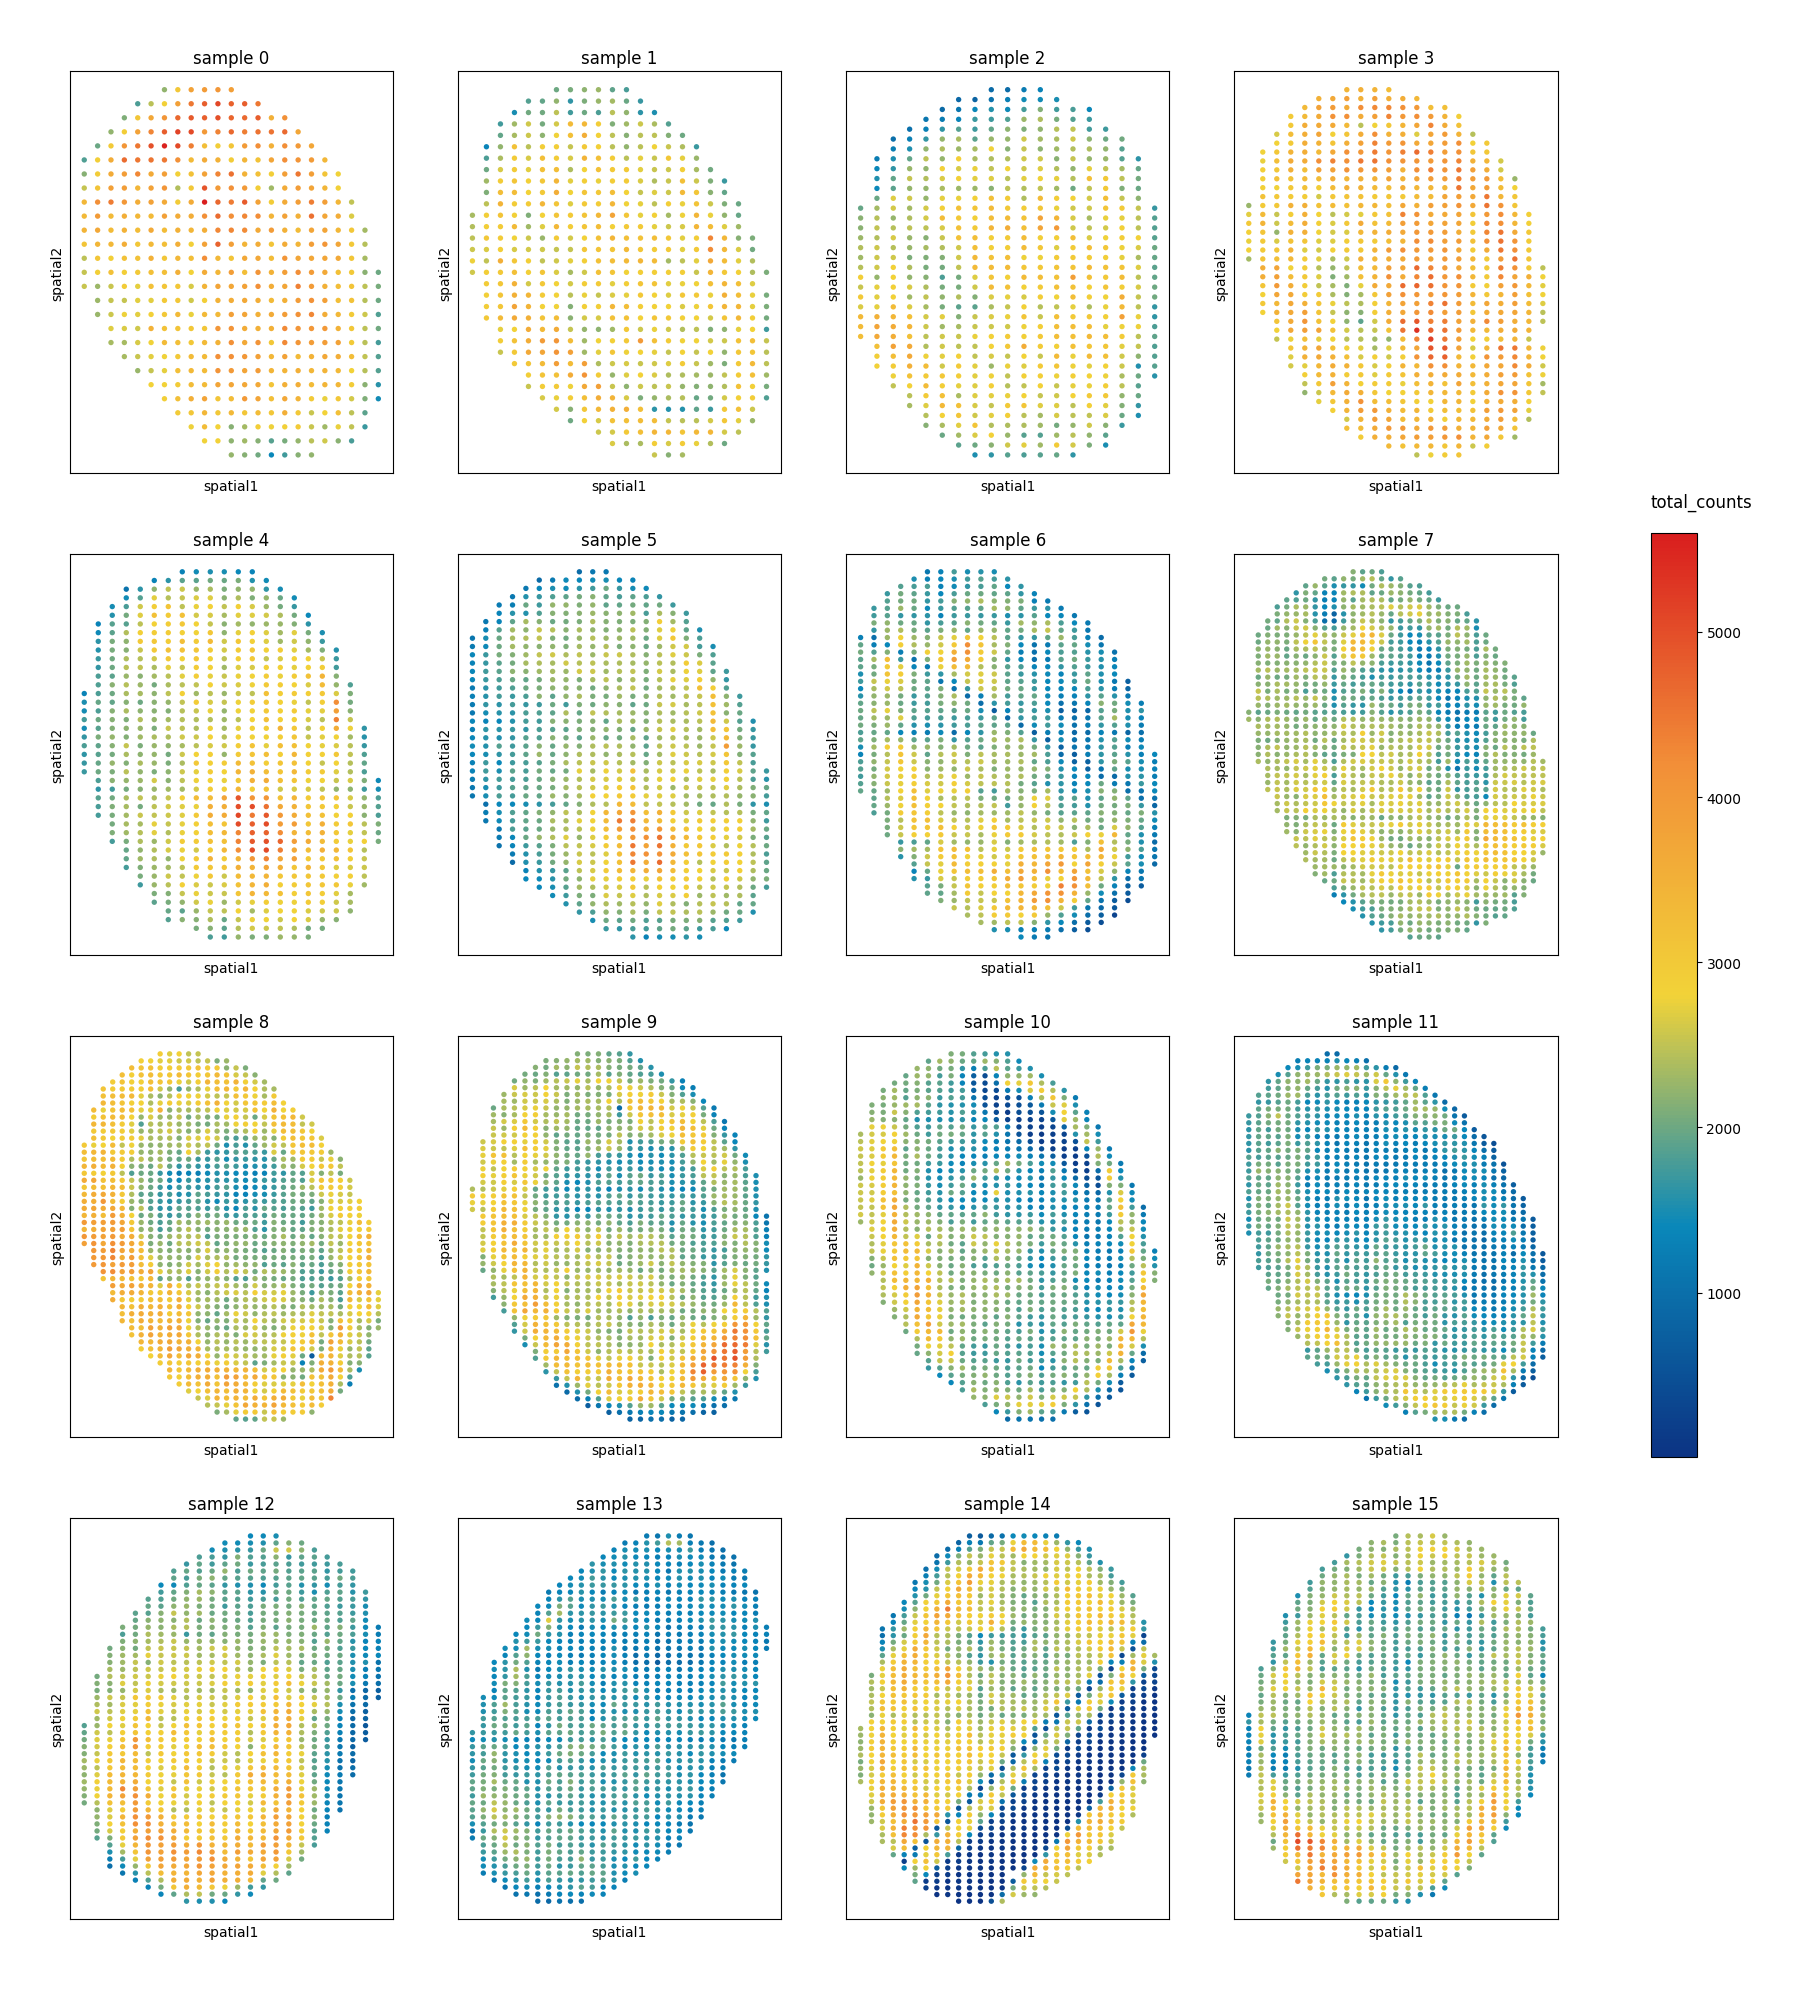

In [6]:
ms_data.plt.ms_spatial_scatter(
    color_by='total_counts',
    ncols=4
)

## Analysis mode

Set global analysis mode to **'isolated'**, all the following methods will run separately on each sample.

In [7]:
ms_data.tl.set_scope_and_mode(mode='isolated')

## Normalization and PCA

In [8]:
ms_data.tl.normalize_total()
ms_data.tl.log1p()
ms_data.tl.pca(use_highly_genes=False, n_pcs=30, res_key='pca')

[2024-08-01 05:40:17][Stereo][53425][Thread-25][139607551002368][ms_pipeline][207][INFO]: data_obj(idx=0) in ms_data start to run normalize_total
[2024-08-01 05:40:17][Stereo][53425][Thread-26][139607542609664][ms_pipeline][207][INFO]: data_obj(idx=1) in ms_data start to run normalize_total
[2024-08-01 05:40:17][Stereo][53425][Thread-27][139607534216960][ms_pipeline][207][INFO]: data_obj(idx=2) in ms_data start to run normalize_total
[2024-08-01 05:40:17][Stereo][53425][Thread-28][139607525824256][ms_pipeline][207][INFO]: data_obj(idx=3) in ms_data start to run normalize_total
[2024-08-01 05:40:17][Stereo][53425][Thread-25][139607551002368][st_pipeline][41][INFO]: start to run normalize_total...
[2024-08-01 05:40:17][Stereo][53425][Thread-29][139607517431552][ms_pipeline][207][INFO]: data_obj(idx=4) in ms_data start to run normalize_total
[2024-08-01 05:40:17][Stereo][53425][Thread-30][139607509038848][ms_pipeline][207][INFO]: data_obj(idx=5) in ms_data start to run normalize_total
[20

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.3s


[2024-08-01 05:40:17][Stereo][53425][Thread-37][139607450289920][st_pipeline][44][INFO]: normalize_total end, consume time 0.1548s.
[2024-08-01 05:40:17][Stereo][53425][Thread-38][139607441897216][st_pipeline][44][INFO]: normalize_total end, consume time 0.1619s.
[2024-08-01 05:40:17][Stereo][53425][Thread-32][139607492253440][st_pipeline][44][INFO]: normalize_total end, consume time 0.1969s.
[2024-08-01 05:40:17][Stereo][53425][Thread-40][139607425111808][st_pipeline][44][INFO]: normalize_total end, consume time 0.1809s.
[2024-08-01 05:40:17][Stereo][53425][Thread-31][139607500646144][st_pipeline][44][INFO]: normalize_total end, consume time 0.2324s.
[2024-08-01 05:40:17][Stereo][53425][Thread-34][139607475468032][st_pipeline][44][INFO]: normalize_total end, consume time 0.2282s.
[2024-08-01 05:40:17][Stereo][53425][Thread-39][139607433504512][st_pipeline][44][INFO]: normalize_total end, consume time 0.2740s.
[2024-08-01 05:40:17][Stereo][53425][Thread-33][139607483860736][st_pipeline

[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  13 out of  16 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  14 out of  16 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


[2024-08-01 05:40:17][Stereo][53425][Thread-46][139607433504512][ms_pipeline][207][INFO]: data_obj(idx=2) in ms_data start to run log1p
[2024-08-01 05:40:17][Stereo][53425][Thread-44][139607458682624][st_pipeline][41][INFO]: start to run log1p...
[2024-08-01 05:40:17][Stereo][53425][Thread-47][139607475468032][ms_pipeline][207][INFO]: data_obj(idx=3) in ms_data start to run log1p
[2024-08-01 05:40:17][Stereo][53425][Thread-48][139607551002368][ms_pipeline][207][INFO]: data_obj(idx=4) in ms_data start to run log1p
[2024-08-01 05:40:17][Stereo][53425][Thread-49][139607542609664][ms_pipeline][207][INFO]: data_obj(idx=5) in ms_data start to run log1p
[2024-08-01 05:40:17][Stereo][53425][Thread-50][139607534216960][ms_pipeline][207][INFO]: data_obj(idx=6) in ms_data start to run log1p
[2024-08-01 05:40:17][Stereo][53425][Thread-45][139607483860736][st_pipeline][41][INFO]: start to run log1p...
[2024-08-01 05:40:17][Stereo][53425][Thread-51][139607525824256][ms_pipeline][207][INFO]: data_obj

[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  13 out of  16 | el

[2024-08-01 05:40:18][Stereo][53425][Thread-53][139607509038848][st_pipeline][44][INFO]: log1p end, consume time 0.2228s.
[2024-08-01 05:40:18][Stereo][53425][Thread-58][139607441897216][st_pipeline][44][INFO]: log1p end, consume time 0.2201s.
[2024-08-01 05:40:18][Stereo][53425][Thread-63][139607441897216][ms_pipeline][207][INFO]: data_obj(idx=0) in ms_data start to run pca
[2024-08-01 05:40:18][Stereo][53425][Thread-64][139607509038848][ms_pipeline][207][INFO]: data_obj(idx=1) in ms_data start to run pca
[2024-08-01 05:40:18][Stereo][53425][Thread-65][139607492253440][ms_pipeline][207][INFO]: data_obj(idx=2) in ms_data start to run pca
[2024-08-01 05:40:18][Stereo][53425][Thread-66][139607525824256][ms_pipeline][207][INFO]: data_obj(idx=3) in ms_data start to run pca
[2024-08-01 05:40:18][Stereo][53425][Thread-63][139607441897216][st_pipeline][41][INFO]: start to run pca...
[2024-08-01 05:40:18][Stereo][53425][Thread-67][139607551002368][ms_pipeline][207][INFO]: data_obj(idx=4) in ms

[Parallel(n_jobs=16)]: Done  14 out of  16 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


[2024-08-01 05:40:35][Stereo][53425][Thread-63][139607441897216][st_pipeline][44][INFO]: pca end, consume time 17.4941s.
[2024-08-01 05:40:36][Stereo][53425][Thread-64][139607509038848][st_pipeline][44][INFO]: pca end, consume time 18.0058s.
[2024-08-01 05:40:36][Stereo][53425][Thread-65][139607492253440][st_pipeline][44][INFO]: pca end, consume time 18.6352s.
[2024-08-01 05:40:38][Stereo][53425][Thread-68][139607542609664][st_pipeline][44][INFO]: pca end, consume time 20.0702s.
[2024-08-01 05:40:38][Stereo][53425][Thread-75][139607458682624][st_pipeline][44][INFO]: pca end, consume time 20.0403s.
[2024-08-01 05:40:38][Stereo][53425][Thread-72][139607483860736][st_pipeline][44][INFO]: pca end, consume time 20.0752s.
[2024-08-01 05:40:38][Stereo][53425][Thread-73][139607475468032][st_pipeline][44][INFO]: pca end, consume time 20.1233s.
[2024-08-01 05:40:38][Stereo][53425][Thread-66][139607525824256][st_pipeline][44][INFO]: pca end, consume time 20.1609s.


[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:   20.1s remaining:  2.4min
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:   20.2s remaining:  1.5min
[Parallel(n_jobs=16)]: Done   4 out of  16 | elapsed:   20.2s remaining:  1.0min
[Parallel(n_jobs=16)]: Done   5 out of  16 | elapsed:   20.2s remaining:   44.4s
[Parallel(n_jobs=16)]: Done   6 out of  16 | elapsed:   20.2s remaining:   33.6s
[Parallel(n_jobs=16)]: Done   7 out of  16 | elapsed:   20.2s remaining:   26.0s
[Parallel(n_jobs=16)]: Done   8 out of  16 | elapsed:   20.3s remaining:   20.3s


[2024-08-01 05:40:38][Stereo][53425][Thread-70][139607517431552][st_pipeline][44][INFO]: pca end, consume time 20.1361s.
[2024-08-01 05:40:38][Stereo][53425][Thread-77][139607433504512][st_pipeline][44][INFO]: pca end, consume time 20.2451s.
[2024-08-01 05:40:38][Stereo][53425][Thread-76][139607450289920][st_pipeline][44][INFO]: pca end, consume time 20.2892s.


[Parallel(n_jobs=16)]: Done   9 out of  16 | elapsed:   20.3s remaining:   15.8s
[Parallel(n_jobs=16)]: Done  10 out of  16 | elapsed:   20.3s remaining:   12.2s
[Parallel(n_jobs=16)]: Done  11 out of  16 | elapsed:   20.4s remaining:    9.3s


[2024-08-01 05:40:39][Stereo][53425][Thread-67][139607551002368][st_pipeline][44][INFO]: pca end, consume time 21.4241s.
[2024-08-01 05:40:39][Stereo][53425][Thread-78][139607425111808][st_pipeline][44][INFO]: pca end, consume time 21.4717s.
[2024-08-01 05:40:39][Stereo][53425][Thread-69][139607534216960][st_pipeline][44][INFO]: pca end, consume time 21.4997s.
[2024-08-01 05:40:39][Stereo][53425][Thread-71][139607500646144][st_pipeline][44][INFO]: pca end, consume time 21.4943s.
[2024-08-01 05:40:39][Stereo][53425][Thread-74][139607467075328][st_pipeline][44][INFO]: pca end, consume time 21.5490s.


[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:   21.6s remaining:    7.2s
[Parallel(n_jobs=16)]: Done  13 out of  16 | elapsed:   21.6s remaining:    5.0s
[Parallel(n_jobs=16)]: Done  14 out of  16 | elapsed:   21.6s remaining:    3.1s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:   21.6s finished


## Running SpaSEG on multi-sample

This process can be seen as an clustering, `min_label` represents the number of cell/bin types you expect, the training will stop when the number of cell/bin types reaches `min_label` or the number of iterations reaches `iterations`.

For more information you can refer to api [ms_data.tl.spa_seg](../content/stereo.algorithm.spa_seg.SpaSeg.main.html).

In [9]:
ins = ms_data.tl.spa_seg(
    sim_weight=0.2,
    con_weight=0.4,
    min_label=7,
    iterations=2100,
    gpu='0' # set gpu to None to run on cpu
)

[2024-08-01 05:40:39][Stereo][53425][MainThread][139627982587712][spaseg][90][INFO]: 
Put the data and model into GPU
[2024-08-01 05:40:39][Stereo][53425][MainThread][139627982587712][spaseg][96][INFO]: input matrix shape: (16, 30, 32, 56)
[2024-08-01 05:40:39][Stereo][53425][MainThread][139627982587712][spaseg][97][INFO]: feed the input matrix to cuda:0
[2024-08-01 05:41:03][Stereo][53425][MainThread][139627982587712][spaseg][104][INFO]: create the model and put it into cuda:0
[2024-08-01 05:41:03][Stereo][53425][MainThread][139627982587712][spaseg][109][INFO]: Start training with 2100 iterations
/data/users/tanliwei/conda/envs/stereopy-rapids/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▌| 1997/2100 [00:34<00:01, 57.23it/s]


Calculate the **ARI** and **NMI** with a cell type annotation by specifying an **obs** column name.

In [10]:
ins.calculate_metrics(true_labels_column='annotation')

{'ARI': 0.26873064929160256, 'NMI': 0.3195126468239716}
{'ARI': 0.08110615364555385, 'NMI': 0.1954948773064302}
{'ARI': 0.18827807221005038, 'NMI': 0.4053059657599966}
{'ARI': 0.22290887792967007, 'NMI': 0.3660943699211063}
{'ARI': 0.13533366762807206, 'NMI': 0.3446437190536986}
{'ARI': 0.35902063390069006, 'NMI': 0.4285834970729185}
{'ARI': 0.39436756327218064, 'NMI': 0.42808327518534317}
{'ARI': 0.18428553012551033, 'NMI': 0.3817282519337245}
{'ARI': 0.1836244318381701, 'NMI': 0.36220595139933853}
{'ARI': 0.2192382705723971, 'NMI': 0.37443756591403415}
{'ARI': 0.36240036850648244, 'NMI': 0.4238053697870983}
{'ARI': 0.2288863031774178, 'NMI': 0.3848514950786887}
{'ARI': 0.1773153616057184, 'NMI': 0.3320517792341717}
{'ARI': 0.18018283309295055, 'NMI': 0.3114488788698329}
{'ARI': 0.29896836535339233, 'NMI': 0.36059379054933655}
{'ARI': 0.12481216176699998, 'NMI': 0.30272499273208353}


## Result visualization

The result will be store as an **obs** column named **'SpaSEG_clusters'**

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

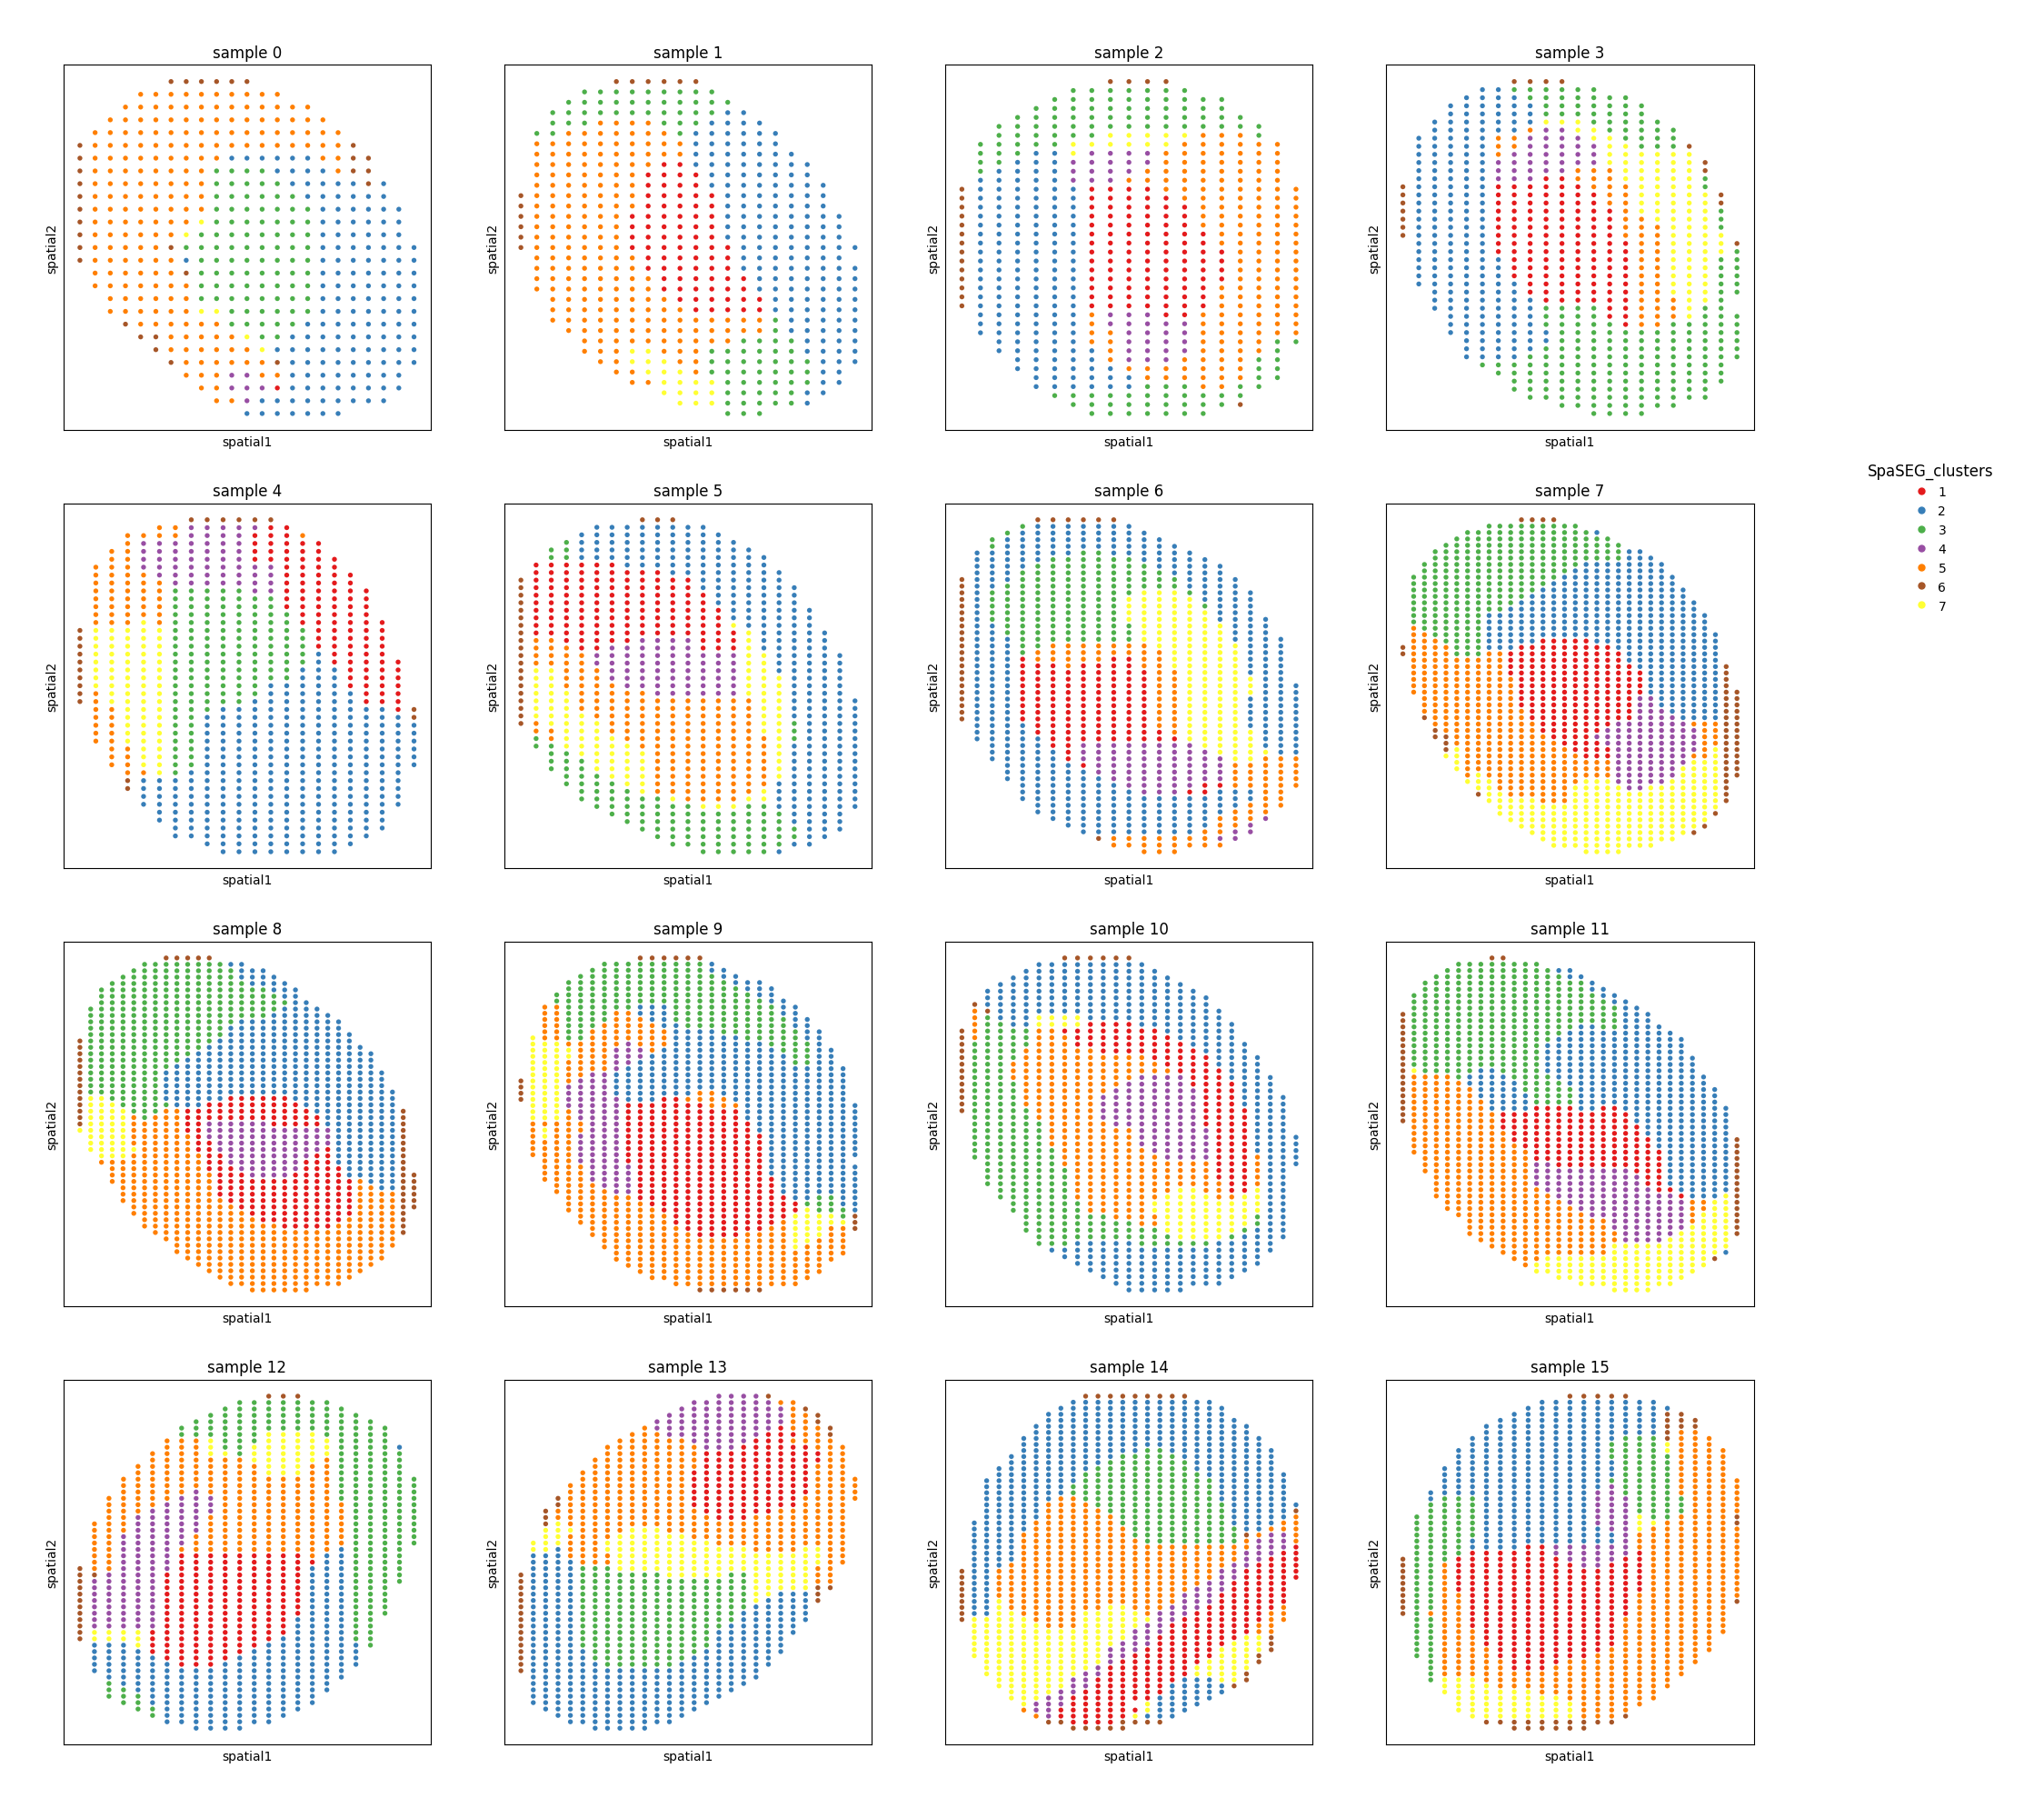

In [11]:
ms_data.plt.ms_spatial_scatter(
    color_by='cluster',
    color_key='SpaSEG_clusters',
    ncols=4
)

## Running SpaSEG on single sample

Here we take sample 0 as example.

The normalization and pca have been run above already, we can run the **SpaSEG** directly.

In [12]:
data = ms_data[0]

Set `result_prefix`(default is **'SpaSEG'**) to an another value to avoid overwriting the result of the above multi-sample analysis.

Here the result will be store as an **obs** column named **'SpaSEG_sample0_clusters'**

In [19]:
ins_single = data.tl.spa_seg(
     sim_weight=0.2,
     con_weight=0.4,
     min_label=7,
     iterations=10000,
     gpu='0', # set gpu to None to run on CPU
     result_prefix='SpaSEG_sample0'
)

[2024-08-01 05:57:39][Stereo][53425][MainThread][139627982587712][spaseg][90][INFO]: 
Put the data and model into GPU
[2024-08-01 05:57:39][Stereo][53425][MainThread][139627982587712][spaseg][96][INFO]: input matrix shape: (1, 30, 23, 27)
[2024-08-01 05:57:39][Stereo][53425][MainThread][139627982587712][spaseg][97][INFO]: feed the input matrix to cuda:0
[2024-08-01 05:57:39][Stereo][53425][MainThread][139627982587712][spaseg][104][INFO]: create the model and put it into cuda:0
[2024-08-01 05:57:39][Stereo][53425][MainThread][139627982587712][spaseg][109][INFO]: Start training with 10000 iterations
/data/users/tanliwei/conda/envs/stereopy-rapids/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 10000/10000 [01:31<00:00, 109.45it/s]


In [20]:
ins_single.calculate_metrics('annotation')

{'ARI': 0.2497199294692335, 'NMI': 0.29387168728926355}


## Result visualization

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

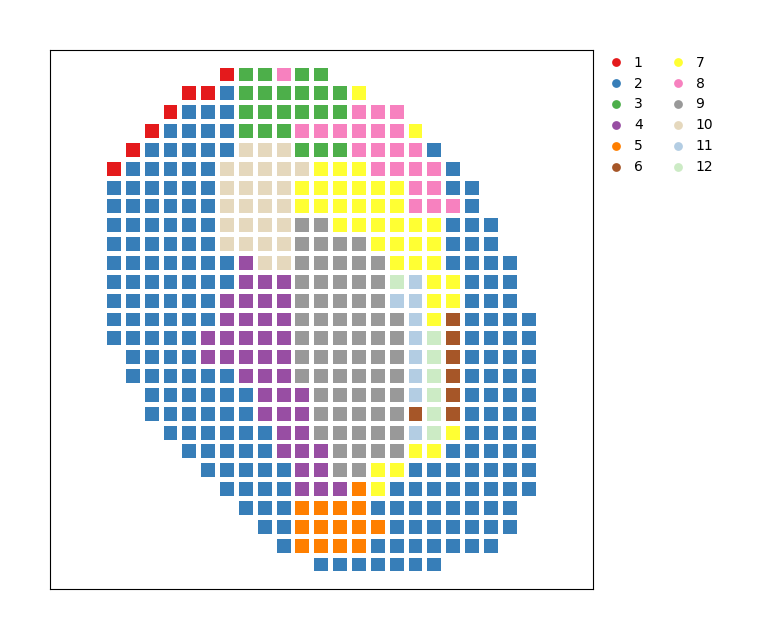

In [24]:
data.plt.cluster_scatter(res_key='SpaSEG_sample0_clusters', show_plotting_scale=False, dot_size=100)